# Simple Forward Simulation of Burgers' Equation with phiflow

In this project, I explore how to run forward simulations of the 1D Burgers' equation using the ΦFlow (phiflow) framework. My goal is to numerically approximate the evolution of an initial state over time and gain hands-on experience with phiflow's differentiable simulation tools, which are well-suited for integration with deep learning frameworks.

The main repository for phiflow is [tum-pbs/PhiFlow](https://github.com/tum-pbs/PhiFlow), and additional API documentation and examples are available at [https://tum-pbs.github.io/PhiFlow/](https://tum-pbs.github.io/PhiFlow/).

This notebook documents my workflow, from setting up the environment to running and visualizing simple simulations. I chose the 1D Burgers' equation because it is a classic nonlinear PDE that exhibits interesting phenomena like shock formation, making it an ideal starting point for experimentation.

You can also try out this notebook in Google Colab: [run in colab]

## Model

As physical model we’ll use Burgers equation. This equation is a very simple, yet non-linear and non-trivial, model equation that can lead to interesting shock formations. Hence, it’s a very good starting point for experiments, and its 1D version (from equation [4]) is given by:

$$
\frac{\partial u}{\partial t} + u \nabla u = \nu \nabla \cdot \nabla u
$$

```markdown
## Importing and Loading PhiFlow

To get started, I need to import the PhiFlow library, specifically the `phi.flow` module, which provides numpy-based operators for fluid flow simulations. PhiFlow is flexible and can switch between different deep learning backends (like PyTorch, TensorFlow, or JAX) by simply changing the import path (e.g., `phi.torch.flow` for PyTorch).

Since this is my first time running the notebook, I’ll install PhiFlow directly from GitHub using pip (see the commented-out line below). If PhiFlow is already installed in the environment, I can skip or comment out the installation step.
```

Next we can define and initialize the necessary constants (denoted by upper-case names): our simulation domain will have `N=128` cells as discretization points for the 1D velocity $u$ in a periodic domain $\Omega$ for the interval $[-1, 1]$. We’ll use 32 time `STEPS` for a time interval of 1, giving us `DT=1/32`. Additionally, we’ll use a viscosity `NU` of $\nu = 0.01/\pi$.

We’ll also define an initial state given by $-\sin(\pi x)$ in the numpy array `INITIAL_NUMPY`, which we’ll use to initialize the velocity $u$ in the simulation in the next cell. This initialization will produce a nice shock in the center of our domain.

Phiflow is object-oriented and centered around field data in the form of grids (internally represented by a tensor object). I.e. you assemble your simulation by constructing a number of grids, and updating them over the course of time steps.

Phiflow internally works with tensors that have named dimensions. This will be especially handy later on for 2D simulations with additional batch and channel dimensions, but for now we’ll simply convert the 1D array into a phiflow tensor that has a single spatial dimension `'x'`.

In [1]:
!pip3 install --upgrade --quiet tensorflow==2.15.0 tensorflow-probability==0.23.0

In [3]:
from phi.flow import *

In [4]:
N = 128
DX = 2./N
STEPS = 32
DT = 1./STEPS
NU = 0.01/(N*np.pi)

# initialization of velocities, cell centers of a CenteredGrid have DX/2 offsets for linspace()
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D numpy array

INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor

In [5]:
velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
vt = advect.semi_lagrangian(velocity, velocity, DT)
#velocity = CenteredGrid(lambda x: -math.sin(np.pi * x), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
#velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1))) # random init

print("Velocity tensor shape: "   + format( velocity.shape )) # == velocity.values.shape
print("Velocity tensor type: "    + format( type(velocity.values) ))
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy('x')[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phiml.math._tensors.Dense'>
Velocity tensor entries 10 to 14: [0.4928982  0.53499764 0.57580817 0.6152316  0.65317285]


In [6]:
velocities = [velocity]
age = 0.
for i in range(STEPS):
    v1 = diffuse.explicit(velocities[-1], NU, DT)
    v2 = advect.semi_lagrangian(v1, v1, DT)
    age += DT
    velocities.append(v2)

print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy('x,vector')[0:5] ))

New velocity content at t=1.0: [[0.0057228 ]
 [0.01716715]
 [0.02861034]
 [0.040052  ]
 [0.05149214]]


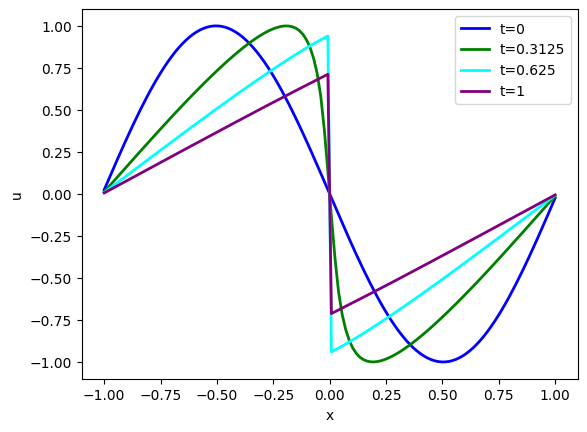

In [7]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector"
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays 

import pylab

fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue',  label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan',  label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

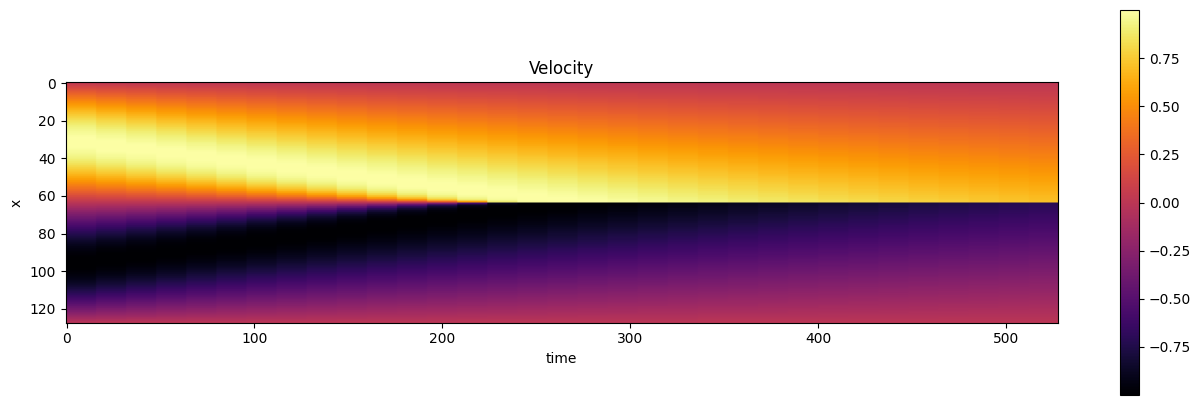

In [8]:
def show_state(a, title):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    # (could also be done with more evaluations of network)
    a=np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)

    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    #print("Resulting image size" +format(a.shape))

    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im) ; pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)
        
vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 ) 

# save for comparison with reconstructions later on
import os; os.makedirs("./temp",exist_ok=True)
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[N,STEPS+1])) # remove batch & channel dimension

show_state(vels_img, "Velocity")